In [205]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import plotly.graph_objects as go
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors as mcolors
from scipy.stats import linregress
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
from tabulate import tabulate
from collections import Counter

%matplotlib inline

In [206]:
df = pd.read_excel('/content/drive/MyDrive/DS Projects/segmentation/Online Retail.xlsx')

In [207]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [208]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [209]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
Quantity,541909.0,9.55225,-80995.0,1.0,3.0,10.0,80995.0,218.081158
InvoiceDate,541909,2011-07-04 13:34:57.156386048,2010-12-01 08:26:00,2011-03-28 11:34:00,2011-07-19 17:17:00,2011-10-19 11:27:00,2011-12-09 12:50:00,NaN
UnitPrice,541909.0,4.611114,-11062.06,1.25,2.08,4.13,38970.0,96.759853
CustomerID,406829.0,15287.69057,12346.0,13953.0,15152.0,16791.0,18287.0,1713.600303


In [210]:
df.describe(include='object').T

,count,unique,top,freq
InvoiceNo,541909,25900,573585,1114
StockCode,541909,4070,85123A,2313
Description,540455,4223,WHITE HANGING HEART T-LIGHT HOLDER,2369
Country,541909,38,United Kingdom,495478


## Data Cleaning

missing values

In [211]:
df.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


In [212]:
# Removing rows with missing values in 'CustomerID' and 'Description' columns
df = df.dropna(subset=['CustomerID', 'Description'])

In [213]:
# Verifying the removal of missing values
df.isnull().sum().sum()

np.int64(0)

duplicate values

In [214]:
df.duplicated().sum()

np.int64(5225)

In [215]:
df[df.duplicated()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908.0,United Kingdom
527,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,2010-12-01 11:45:00,2.10,17908.0,United Kingdom
537,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,2010-12-01 11:45:00,2.95,17908.0,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-01 11:45:00,4.95,17908.0,United Kingdom
555,536412,22327,ROUND SNACK BOXES SET OF 4 SKULLS,1,2010-12-01 11:49:00,2.95,17920.0,United Kingdom
...,...,...,...,...,...,...,...,...
541675,581538,22068,BLACK PIRATE TREASURE CHEST,1,2011-12-09 11:34:00,0.39,14446.0,United Kingdom
541689,581538,23318,BOX OF 6 MINI VINTAGE CRACKERS,1,2011-12-09 11:34:00,2.49,14446.0,United Kingdom
541692,581538,22992,REVOLVER WOODEN RULER,1,2011-12-09 11:34:00,1.95,14446.0,United Kingdom
541699,581538,22694,WICKER STAR,1,2011-12-09 11:34:00,2.10,14446.0,United Kingdom


In [216]:
df.drop_duplicates(inplace=True)

In [217]:
df.shape[0]

401604

Cancelled transactions

In [218]:
# Filter out the rows with InvoiceNo starting with "C" and create a new column indicating the transaction status
df['Transaction_Status'] = np.where(df['InvoiceNo'].astype(str).str.startswith('C'), 'Cancelled', 'Completed')


In [219]:
# Analyze the characteristics of these rows (considering the new column)
cancelled_transactions = df[df['Transaction_Status'] == 'Cancelled']
cancelled_transactions.describe().drop('CustomerID', axis=1)

,Quantity,InvoiceDate,UnitPrice
count,8872.000000,8872,8872.000000
mean,-30.774910,2011-06-27 09:06:05.024797184,18.899512
min,-80995.000000,2010-12-01 09:41:00,0.010000
25%,-6.000000,2011-03-23 11:23:45,1.450000
50%,-2.000000,2011-07-11 13:51:00,2.950000
75%,-1.000000,2011-10-06 20:36:00,4.950000
max,-1.000000,2011-12-09 11:58:00,38970.000000
std,1172.249902,NaN,445.190864


In [220]:
# Finding the percentage of cancelled transactions
cancelled_percentage = (cancelled_transactions.shape[0] / df.shape[0]) * 100

In [221]:
print(f"The percentage of cancelled transactions: {cancelled_percentage:.2f}%")

The percentage of cancelled transactions: 2.21%


Stockcode Anomalies

In [222]:
df['StockCode'].nunique()

3684

In [223]:
# Finding the top 10 most frequent stock codes
top_10_stock_codes = df['StockCode'].value_counts(normalize=True).head(10) * 100

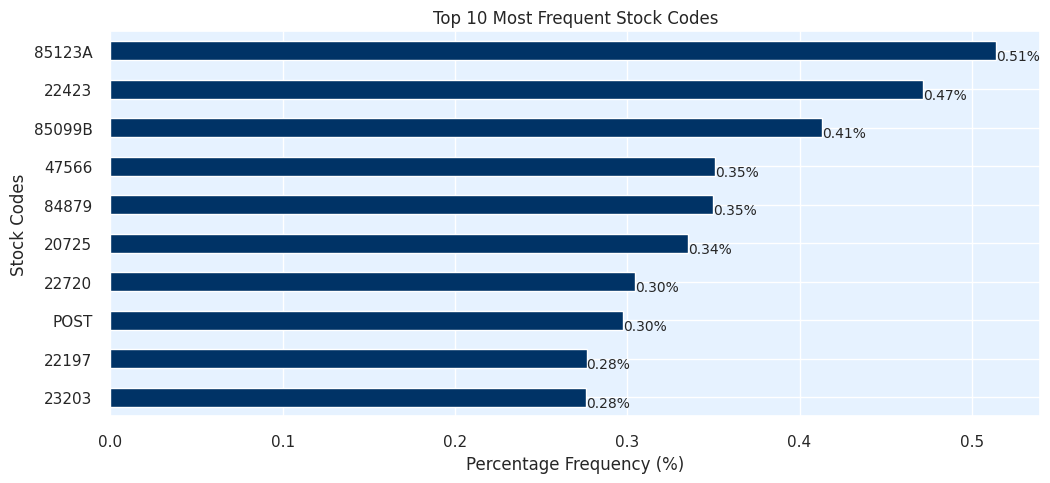

In [224]:
# Plotting the top 10 most frequent stock codes
plt.figure(figsize=(12, 5))
top_10_stock_codes.plot(kind='barh', color='#003366')

# Adding the percentage frequency on the bars
for index, value in enumerate(top_10_stock_codes):
    plt.text(value, index+0.25, f'{value:.2f}%', fontsize=10)

plt.title('Top 10 Most Frequent Stock Codes')
plt.xlabel('Percentage Frequency (%)')
plt.ylabel('Stock Codes')
plt.gca().invert_yaxis()
plt.show()

In [225]:
# Finding the number of numeric characters in each unique stock code
unique_stock_codes = df['StockCode'].unique()
numeric_char_counts_in_unique_codes = pd.Series(unique_stock_codes).apply(lambda x: sum(c.isdigit() for c in str(x))).value_counts()

# Printing the value counts for unique stock codes
print("Value counts of numeric character frequencies in unique stock codes:")
print("-"*70)
print(numeric_char_counts_in_unique_codes)

Value counts of numeric character frequencies in unique stock codes:
----------------------------------------------------------------------
5    3676
0       7
1       1
Name: count, dtype: int64


In [226]:
# Finding and printing the stock codes with 0 and 1 numeric characters
anomalous_stock_codes = [code for code in unique_stock_codes if sum(c.isdigit() for c in str(code)) in (0, 1)]

# Printing each stock code on a new line
print("Anomalous stock codes:")
print("-"*22)
for code in anomalous_stock_codes:
    print(code)

Anomalous stock codes:
----------------------
POST
D
C2
M
BANK CHARGES
PADS
DOT
CRUK


In [227]:
# Removing rows with anomalous stock codes from the dataset
df = df[~df['StockCode'].isin(anomalous_stock_codes)]

In [228]:
df.shape[0]

399689

description column

In [229]:
df['Description'].value_counts()

,count
Description,
WHITE HANGING HEART T-LIGHT HOLDER,2058
REGENCY CAKESTAND 3 TIER,1894
JUMBO BAG RED RETROSPOT,1659
PARTY BUNTING,1409
ASSORTED COLOUR BIRD ORNAMENT,1405
...,...
RED ROSE AND LACE C/COVER,1
LIGHT DECORATION BATTERY OPERATED,1
"LETTER ""O"" BLING KEY RING",1


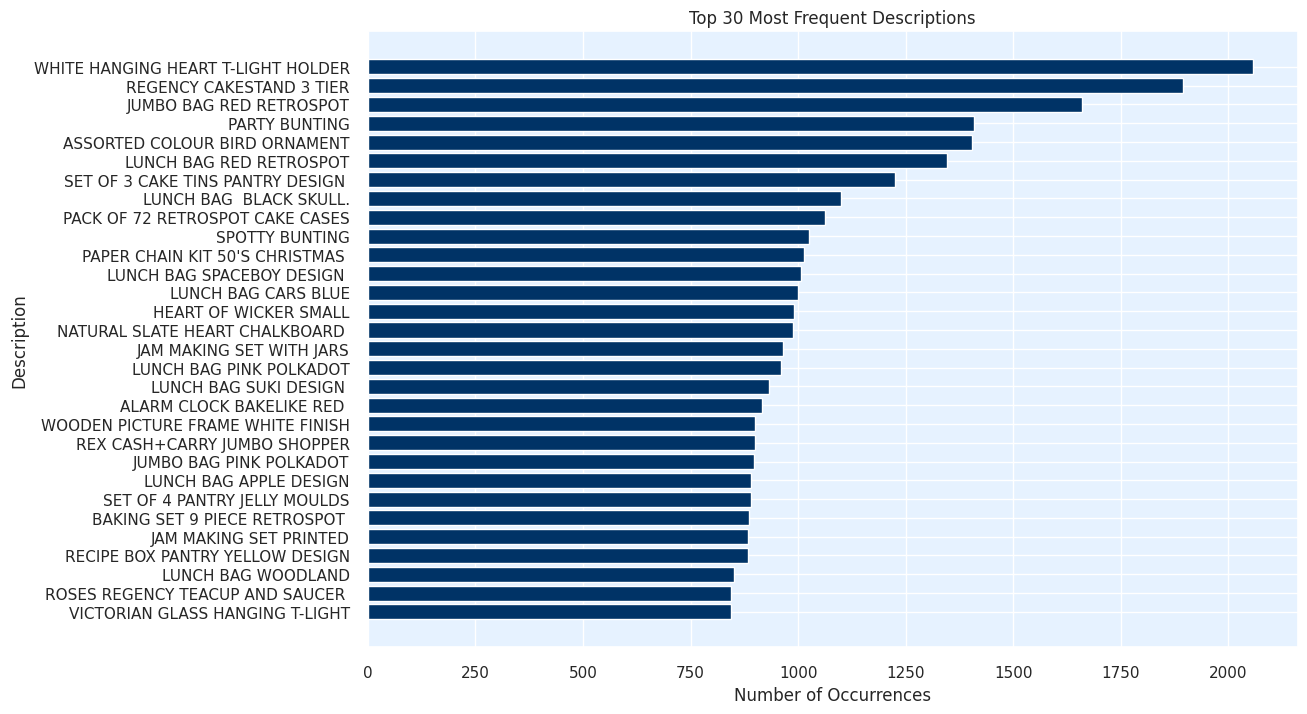

In [230]:
# Get the top 30 descriptions
top_30_descriptions = df['Description'].value_counts()[:30]

# Plotting
plt.figure(figsize=(12,8))
plt.barh(top_30_descriptions.index[::-1], top_30_descriptions.values[::-1], color='#003366')

# Adding labels and title
plt.xlabel('Number of Occurrences')
plt.ylabel('Description')
plt.title('Top 30 Most Frequent Descriptions')

# Show the plot
plt.show()

In [231]:
# Find unique descriptions containing lowercase characters
lowercase_descriptions = df['Description'].unique()
lowercase_descriptions = [desc for desc in lowercase_descriptions if any(char.islower() for char in desc)]

# Print the unique descriptions containing lowercase characters
print("The unique descriptions containing lowercase characters are:")
print("-"*60)
for desc in lowercase_descriptions:
    print(desc)

The unique descriptions containing lowercase characters are:
------------------------------------------------------------
BAG 500g SWIRLY MARBLES
POLYESTER FILLER PAD 45x45cm
POLYESTER FILLER PAD 45x30cm
POLYESTER FILLER PAD 40x40cm
FRENCH BLUE METAL DOOR SIGN No
BAG 250g SWIRLY MARBLES
BAG 125g SWIRLY MARBLES
3 TRADITIONAl BISCUIT CUTTERS  SET
NUMBER TILE COTTAGE GARDEN No
FOLK ART GREETING CARD,pack/12
ESSENTIAL BALM 3.5g TIN IN ENVELOPE
POLYESTER FILLER PAD 65CMx65CM
NUMBER TILE VINTAGE FONT No 
POLYESTER FILLER PAD 30CMx30CM
POLYESTER FILLER PAD 60x40cm
FLOWERS HANDBAG blue and orange
Next Day Carriage
THE KING GIFT BAG 25x24x12cm
High Resolution Image


In [232]:
service_related_descriptions = ["Next Day Carriage", "High Resolution Image"]

In [233]:
# Remove rows with service-related information in the description
df = df[~df['Description'].isin(service_related_descriptions)]

In [234]:
# Standardize the text to uppercase to maintain uniformity across the dataset
df['Description'] = df['Description'].str.upper()

In [235]:
df.shape[0]

399606

Zero unit prices

In [236]:
df['UnitPrice'].describe()

,UnitPrice
count,399606.000000
mean,2.904957
std,4.448796
min,0.000000
25%,1.250000
50%,1.950000
75%,3.750000
max,649.500000


In [237]:
df[df['UnitPrice']==0].describe()[['Quantity']]

,Quantity
count,33.000000
mean,420.515152
min,1.000000
25%,2.000000
50%,11.000000
75%,36.000000
max,12540.000000
std,2176.713608


In [238]:
# Removing records with a unit price of zero to avoid potential data entry errors
df = df[df['UnitPrice'] > 0]

Outliers

In [239]:
# Resetting the index of the cleaned dataset
df.reset_index(drop=True, inplace=True)

In [240]:
df.shape[0]

399573

## Feature Engineering

RMF Features (RFM is a method used for analyzing customer value and segmenting the customer base.)

Recency (R)

In [241]:
# Convert InvoiceDate to datetime type
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Convert InvoiceDate to datetime and extract only the date
df['InvoiceDay'] = df['InvoiceDate'].dt.date

# Find the most recent purchase date for each customer
customer_data = df.groupby('CustomerID')['InvoiceDay'].max().reset_index()

# Find the most recent date in the entire dataset
most_recent_date = df['InvoiceDay'].max()

# Convert InvoiceDay to datetime type before subtraction
customer_data['InvoiceDay'] = pd.to_datetime(customer_data['InvoiceDay'])
most_recent_date = pd.to_datetime(most_recent_date)

# Calculate the number of days since the last purchase for each customer
customer_data['Days_Since_Last_Purchase'] = (most_recent_date - customer_data['InvoiceDay']).dt.days

# Remove the InvoiceDay column
customer_data.drop(columns=['InvoiceDay'], inplace=True)

In [242]:
customer_data.head()

,CustomerID,Days_Since_Last_Purchase
0,12346.0,325
1,12347.0,2
2,12348.0,75
3,12349.0,18
4,12350.0,310


Frequency (F)

In [243]:
# Calculate the total number of transactions made by each customer
total_transactions = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
total_transactions.rename(columns={'InvoiceNo': 'Total_Transactions'}, inplace=True)

# Calculate the total number of products purchased by each customer
total_products_purchased = df.groupby('CustomerID')['Quantity'].sum().reset_index()
total_products_purchased.rename(columns={'Quantity': 'Total_Products_Purchased'}, inplace=True)

# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, total_transactions, on='CustomerID')
customer_data = pd.merge(customer_data, total_products_purchased, on='CustomerID')

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased
0,12346.0,325,2,0
1,12347.0,2,7,2458
2,12348.0,75,4,2332
3,12349.0,18,1,630
4,12350.0,310,1,196


Monetary (M)

In [244]:
# Calculate the total spend by each customer
df['Total_Spend'] = df['UnitPrice'] * df['Quantity']
total_spend = df.groupby('CustomerID')['Total_Spend'].sum().reset_index()

# Calculate the average transaction value for each customer
average_transaction_value = total_spend.merge(total_transactions, on='CustomerID')
average_transaction_value['Average_Transaction_Value'] = average_transaction_value['Total_Spend'] / average_transaction_value['Total_Transactions']

# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, total_spend, on='CustomerID')
customer_data = pd.merge(customer_data, average_transaction_value[['CustomerID', 'Average_Transaction_Value']], on='CustomerID')

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value
0,12346.0,325,2,0,0.00,0.000000
1,12347.0,2,7,2458,4310.00,615.714286
2,12348.0,75,4,2332,1437.24,359.310000
3,12349.0,18,1,630,1457.55,1457.550000
4,12350.0,310,1,196,294.40,294.400000


 Product Diversity

In [245]:
# Calculate the number of unique products purchased by each customer
unique_products_purchased = df.groupby('CustomerID')['StockCode'].nunique().reset_index()
unique_products_purchased.rename(columns={'StockCode': 'Unique_Products_Purchased'}, inplace=True)

# Merge the new feature into the customer_data dataframe
customer_data = pd.merge(customer_data, unique_products_purchased, on='CustomerID')

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased
0,12346.0,325,2,0,0.00,0.000000,1
1,12347.0,2,7,2458,4310.00,615.714286,103
2,12348.0,75,4,2332,1437.24,359.310000,21
3,12349.0,18,1,630,1457.55,1457.550000,72
4,12350.0,310,1,196,294.40,294.400000,16


 Behavioral Features

In [246]:
# Extract day of week and hour from InvoiceDate
df['Day_Of_Week'] = df['InvoiceDate'].dt.dayofweek
df['Hour'] = df['InvoiceDate'].dt.hour

# Calculate the average number of days between consecutive purchases
days_between_purchases = df.groupby('CustomerID')['InvoiceDay'].apply(lambda x: (x.diff().dropna()).apply(lambda y: y.days))
average_days_between_purchases = days_between_purchases.groupby('CustomerID').mean().reset_index()
average_days_between_purchases.rename(columns={'InvoiceDay': 'Average_Days_Between_Purchases'}, inplace=True)

# Find the favorite shopping day of the week
favorite_shopping_day = df.groupby(['CustomerID', 'Day_Of_Week']).size().reset_index(name='Count')
favorite_shopping_day = favorite_shopping_day.loc[favorite_shopping_day.groupby('CustomerID')['Count'].idxmax()][['CustomerID', 'Day_Of_Week']]

# Find the favorite shopping hour of the day
favorite_shopping_hour = df.groupby(['CustomerID', 'Hour']).size().reset_index(name='Count')
favorite_shopping_hour = favorite_shopping_hour.loc[favorite_shopping_hour.groupby('CustomerID')['Count'].idxmax()][['CustomerID', 'Hour']]

# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, average_days_between_purchases, on='CustomerID')
customer_data = pd.merge(customer_data, favorite_shopping_day, on='CustomerID')
customer_data = pd.merge(customer_data, favorite_shopping_hour, on='CustomerID')

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour
0,12346.0,325,2,0,0.00,0.000000,1,0.000000,1,10
1,12347.0,2,7,2458,4310.00,615.714286,103,2.016575,1,14
2,12348.0,75,4,2332,1437.24,359.310000,21,10.884615,3,19
3,12349.0,18,1,630,1457.55,1457.550000,72,0.000000,0,9
4,12350.0,310,1,196,294.40,294.400000,16,0.000000,2,16


Geographic Features

In [247]:
df['Country'].value_counts(normalize=True).head()

,proportion
Country,
United Kingdom,0.890971
Germany,0.022722
France,0.020402
EIRE,0.018440
Spain,0.006162


In [248]:
# Group by CustomerID and Country to get the number of transactions per country for each customer
customer_country = df.groupby(['CustomerID', 'Country']).size().reset_index(name='Number_of_Transactions')

# Get the country with the maximum number of transactions for each customer (in case a customer has transactions from multiple countries)
customer_main_country = customer_country.sort_values('Number_of_Transactions', ascending=False).drop_duplicates('CustomerID')

# Create a binary column indicating whether the customer is from the UK or not
customer_main_country['Is_UK'] = customer_main_country['Country'].apply(lambda x: 1 if x == 'United Kingdom' else 0)

# Merge this data with our customer_data dataframe
customer_data = pd.merge(customer_data, customer_main_country[['CustomerID', 'Is_UK']], on='CustomerID', how='left')

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK
0,12346.0,325,2,0,0.00,0.000000,1,0.000000,1,10,1
1,12347.0,2,7,2458,4310.00,615.714286,103,2.016575,1,14,0
2,12348.0,75,4,2332,1437.24,359.310000,21,10.884615,3,19,0
3,12349.0,18,1,630,1457.55,1457.550000,72,0.000000,0,9,0
4,12350.0,310,1,196,294.40,294.400000,16,0.000000,2,16,0


In [249]:
customer_data['Is_UK'].value_counts()

,count
Is_UK,
1,3866
0,416


Cancellation Insights

In [250]:
# Calculate the total number of transactions made by each customer
total_transactions = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()

# Calculate the number of cancelled transactions for each customer
cancelled_transactions = df[df['Transaction_Status'] == 'Cancelled']
cancellation_frequency = cancelled_transactions.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
cancellation_frequency.rename(columns={'InvoiceNo': 'Cancellation_Frequency'}, inplace=True)

# Merge the Cancellation Frequency data into the customer_data dataframe
customer_data = pd.merge(customer_data, cancellation_frequency, on='CustomerID', how='left')

# Replace NaN values with 0 (for customers who have not cancelled any transaction)
customer_data['Cancellation_Frequency'].fillna(0, inplace=True)

# Calculate the Cancellation Rate
customer_data['Cancellation_Rate'] = customer_data['Cancellation_Frequency'] / total_transactions['InvoiceNo']

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate
0,12346.0,325,2,0,0.00,0.000000,1,0.000000,1,10,1,1.0,0.5
1,12347.0,2,7,2458,4310.00,615.714286,103,2.016575,1,14,0,0.0,0.0
2,12348.0,75,4,2332,1437.24,359.310000,21,10.884615,3,19,0,0.0,0.0
3,12349.0,18,1,630,1457.55,1457.550000,72,0.000000,0,9,0,0.0,0.0
4,12350.0,310,1,196,294.40,294.400000,16,0.000000,2,16,0,0.0,0.0


Seasonality & Trends

In [251]:
# Extract month and year from InvoiceDate
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month

# Calculate monthly spending for each customer
monthly_spending = df.groupby(['CustomerID', 'Year', 'Month'])['Total_Spend'].sum().reset_index()

# Calculate Seasonal Buying Patterns: We are using monthly frequency as a proxy for seasonal buying patterns
seasonal_buying_patterns = monthly_spending.groupby('CustomerID')['Total_Spend'].agg(['mean', 'std']).reset_index()
seasonal_buying_patterns.rename(columns={'mean': 'Monthly_Spending_Mean', 'std': 'Monthly_Spending_Std'}, inplace=True)

# Replace NaN values in Monthly_Spending_Std with 0, implying no variability for customers with single transaction month
seasonal_buying_patterns['Monthly_Spending_Std'].fillna(0, inplace=True)

In [252]:
# Calculate Trends in Spending
# We are using the slope of the linear trend line fitted to the customer's spending over time as an indicator of spending trends
def calculate_trend(spend_data):
    # If there are more than one data points, we calculate the trend using linear regression
    if len(spend_data) > 1:
        x = np.arange(len(spend_data))
        slope, _, _, _, _ = linregress(x, spend_data)
        return slope
    # If there is only one data point, no trend can be calculated, hence we return 0
    else:
        return 0

In [253]:
# Apply the calculate_trend function to find the spending trend for each customer
spending_trends = monthly_spending.groupby('CustomerID')['Total_Spend'].apply(calculate_trend).reset_index()
spending_trends.rename(columns={'Total_Spend': 'Spending_Trend'}, inplace=True)

# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, seasonal_buying_patterns, on='CustomerID')
customer_data = pd.merge(customer_data, spending_trends, on='CustomerID')

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
0,12346.0,325,2,0,0.00,0.000000,1,0.000000,1,10,1,1.0,0.5,0.000000,0.000000,0.000000
1,12347.0,2,7,2458,4310.00,615.714286,103,2.016575,1,14,0,0.0,0.0,615.714286,341.070789,4.486071
2,12348.0,75,4,2332,1437.24,359.310000,21,10.884615,3,19,0,0.0,0.0,359.310000,203.875689,-100.884000
3,12349.0,18,1,630,1457.55,1457.550000,72,0.000000,0,9,0,0.0,0.0,1457.550000,0.000000,0.000000
4,12350.0,310,1,196,294.40,294.400000,16,0.000000,2,16,0,0.0,0.0,294.400000,0.000000,0.000000


In [254]:
# Changing the data type of 'CustomerID' to string as it is a unique identifier and not used in mathematical operations
customer_data['CustomerID'] = customer_data['CustomerID'].astype(str)

# Convert data types of columns to optimal types
customer_data = customer_data.convert_dtypes()

In [255]:
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
0,12346.0,325,2,0,0.0,0.0,1,0.0,1,10,1,1,0.5,0.0,0.0,0.0
1,12347.0,2,7,2458,4310.0,615.714286,103,2.016575,1,14,0,0,0.0,615.714286,341.070789,4.486071
2,12348.0,75,4,2332,1437.24,359.31,21,10.884615,3,19,0,0,0.0,359.31,203.875689,-100.884
3,12349.0,18,1,630,1457.55,1457.55,72,0.0,0,9,0,0,0.0,1457.55,0.0,0.0
4,12350.0,310,1,196,294.4,294.4,16,0.0,2,16,0,0,0.0,294.4,0.0,0.0


Available columns: ['CustomerID', 'Days_Since_Last_Purchase', 'Total_Transactions', 'Total_Products_Purchased', 'Total_Spend', 'Average_Transaction_Value', 'Unique_Products_Purchased', 'Average_Days_Between_Purchases', 'Day_Of_Week', 'Hour', 'Is_UK', 'Cancellation_Frequency', 'Cancellation_Rate', 'Monthly_Spending_Mean', 'Monthly_Spending_Std', 'Spending_Trend']
Columns to plot: ['Days_Since_Last_Purchase', 'Total_Transactions', 'Total_Products_Purchased', 'Total_Spend', 'Average_Transaction_Value', 'Unique_Products_Purchased', 'Average_Days_Between_Purchases', 'Cancellation_Frequency', 'Cancellation_Rate', 'Monthly_Spending_Mean', 'Monthly_Spending_Std', 'Spending_Trend']


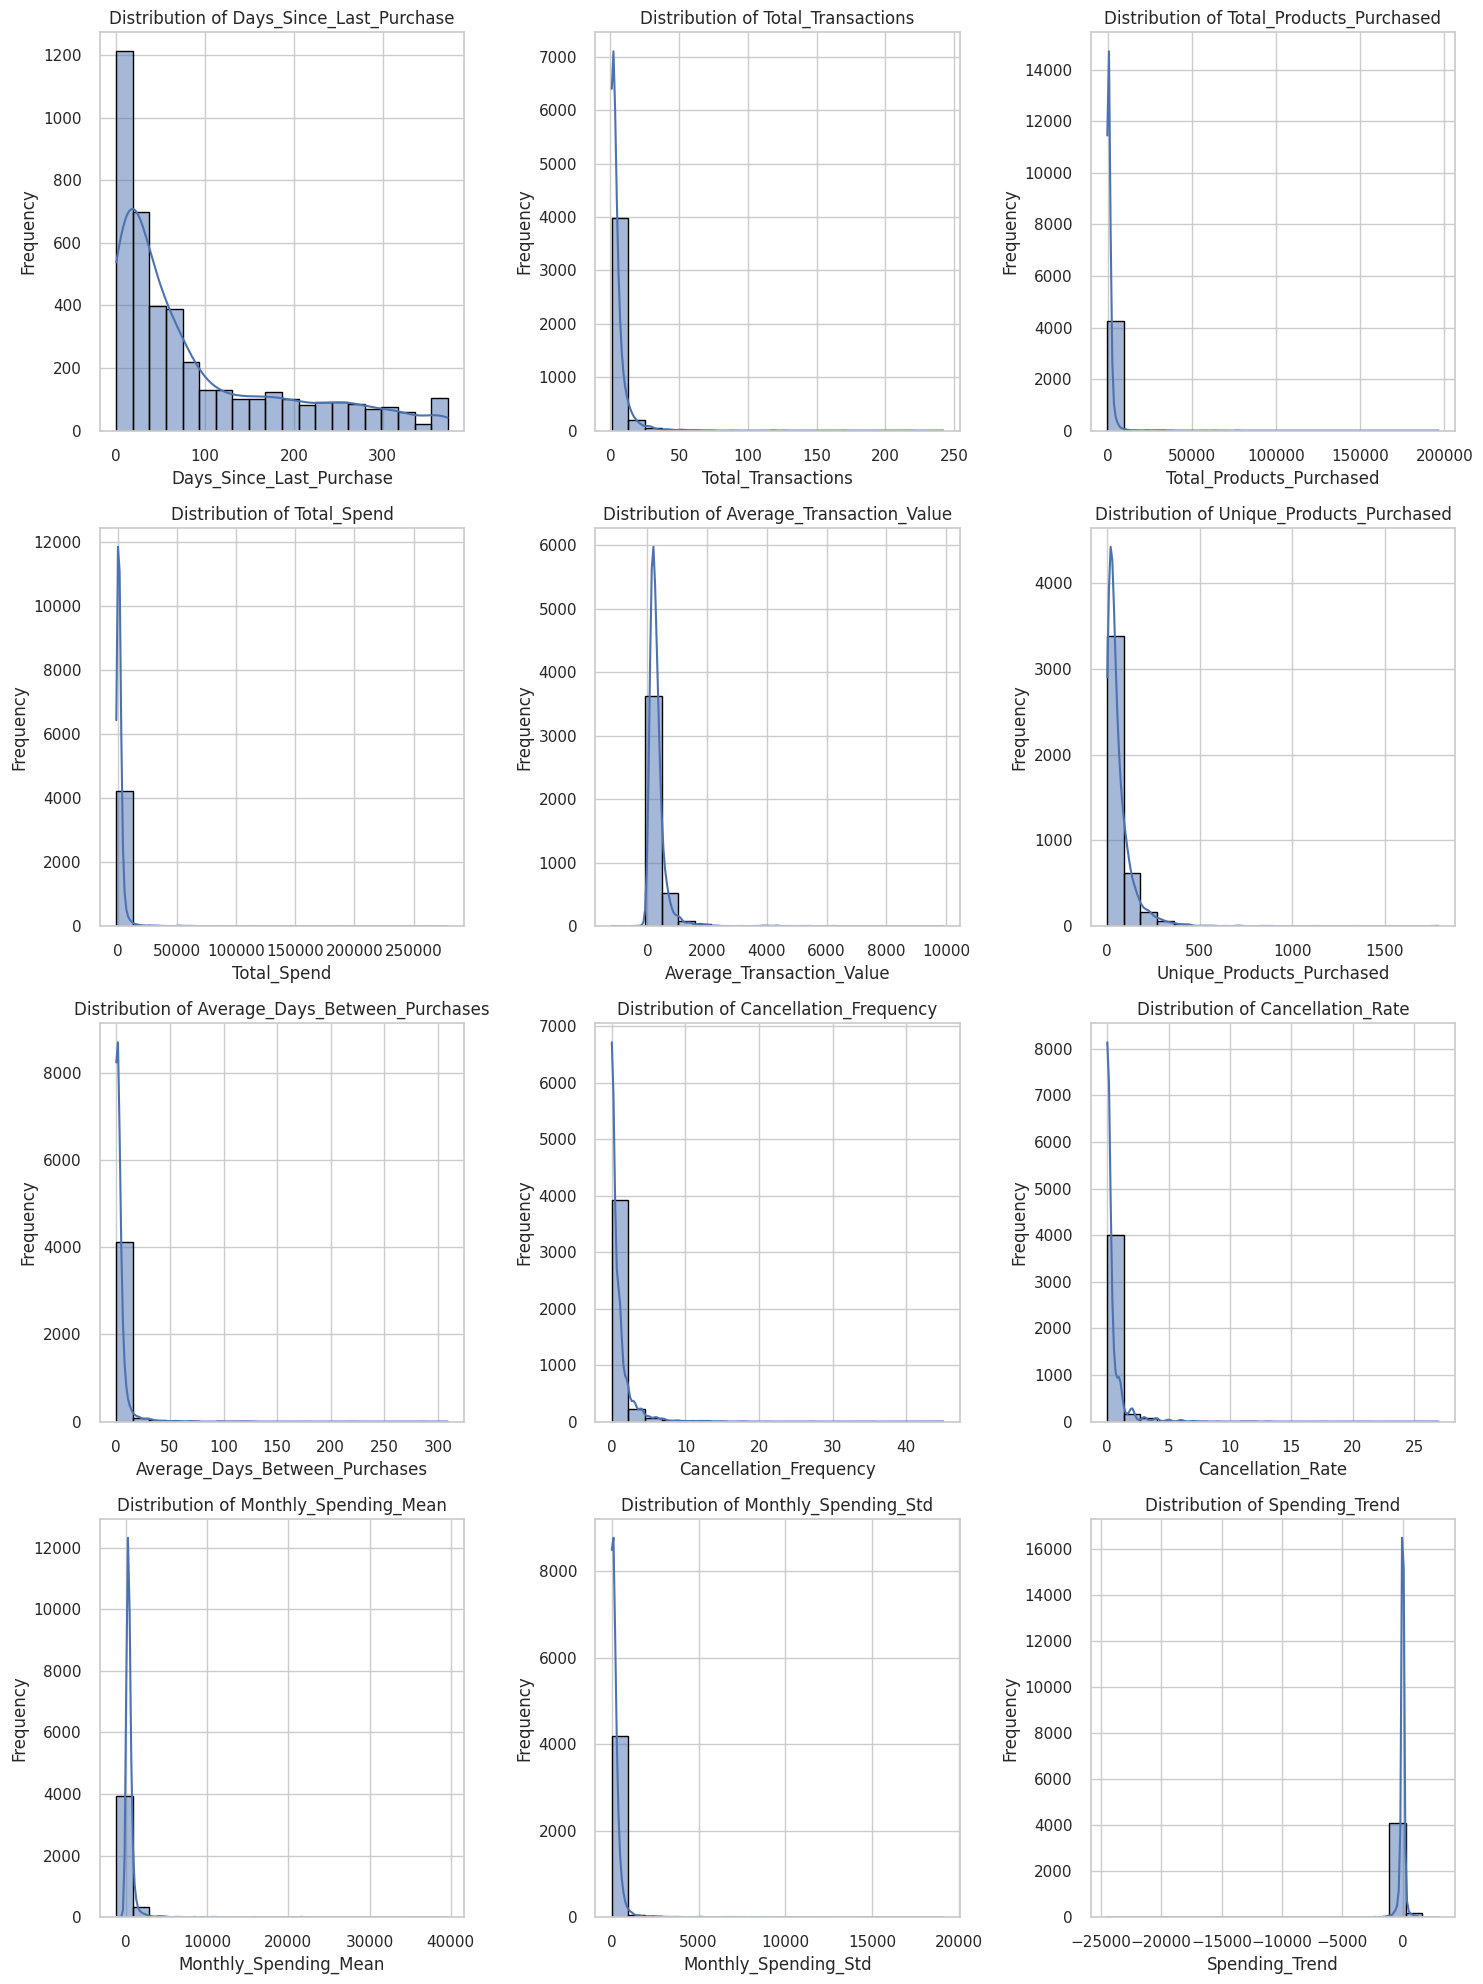

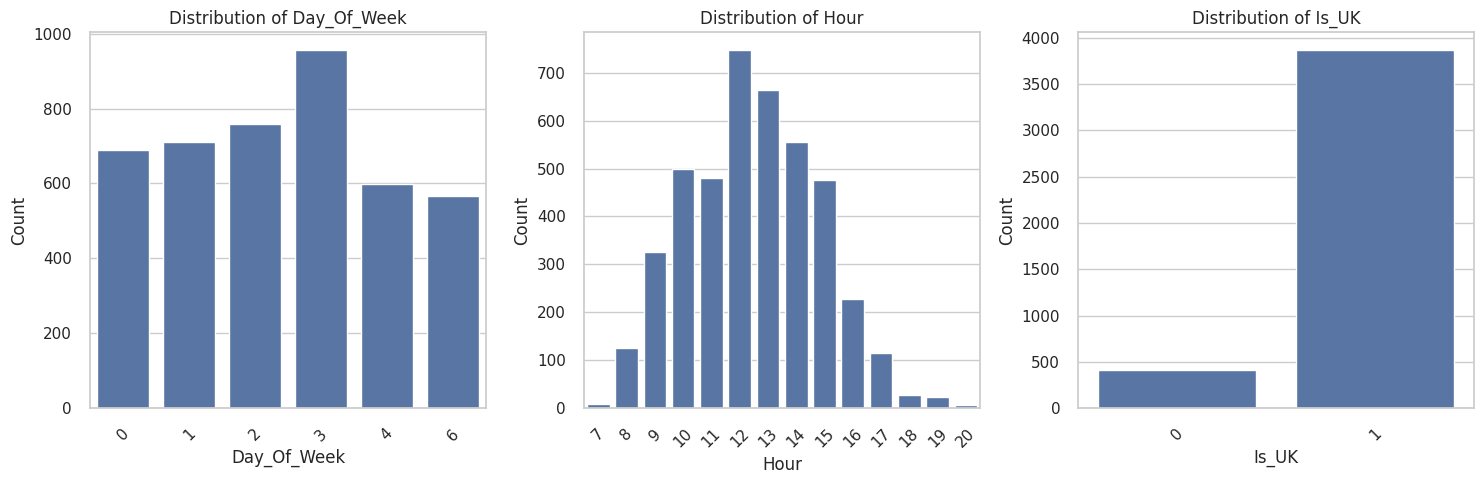

In [256]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")

# 1. First check which columns actually exist in your DataFrame
available_cols = customer_data.columns.tolist()
print("Available columns:", available_cols)

# 2. Filter numeric_cols to only include existing columns
numeric_cols = [
    'Days_Since_Last_Purchase', 'Total_Transactions', 'Total_Products_Purchased',
    'Total_Spend', 'Average_Transaction_Value', 'Unique_Products_Purchased',
    'Average_Days_Between_Purchases', 'Cancellation_Frequency', 'Cancellation_Rate',
    'Monthly_Spending_Mean', 'Monthly_Spending_Std', 'Spending_Trend'
]

# Keep only columns that exist
numeric_cols = [col for col in numeric_cols if col in available_cols]
print("Columns to plot:", numeric_cols)

# 3. Plot numeric columns
plt.figure(figsize=(15, 20))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(4, 3, i)

    # Handle potential negative values for log scale
    use_log = (col in ['Total_Spend', 'Total_Products_Purchased']) and (customer_data[col] > 0).all()

    sns.histplot(data=customer_data, x=col, kde=True, bins=20,
                log_scale=use_log, edgecolor='black')

    plt.title(f'Distribution of {col}', fontsize=12)
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# 4. Plot categorical columns
categorical_cols = ['Day_Of_Week', 'Hour', 'Is_UK']
categorical_cols = [col for col in categorical_cols if col in available_cols]

plt.figure(figsize=(15, 5))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(1, 3, i)
    sns.countplot(data=customer_data, x=col)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [257]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4282 entries, 0 to 4281
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   CustomerID                      4282 non-null   string 
 1   Days_Since_Last_Purchase        4282 non-null   Int64  
 2   Total_Transactions              4282 non-null   Int64  
 3   Total_Products_Purchased        4282 non-null   Int64  
 4   Total_Spend                     4282 non-null   Float64
 5   Average_Transaction_Value       4282 non-null   Float64
 6   Unique_Products_Purchased       4282 non-null   Int64  
 7   Average_Days_Between_Purchases  4282 non-null   Float64
 8   Day_Of_Week                     4282 non-null   Int32  
 9   Hour                            4282 non-null   Int32  
 10  Is_UK                           4282 non-null   Int64  
 11  Cancellation_Frequency          4282 non-null   Int64  
 12  Cancellation_Rate               42

## Outlier Detection and Treatment

In [258]:
# Initializing the IsolationForest model with a contamination parameter of 0.05
model = IsolationForest(contamination=0.05, random_state=0)

# Fitting the model on our dataset (converting DataFrame to NumPy to avoid warning)
customer_data['Outlier_Scores'] = model.fit_predict(customer_data.iloc[:, 1:].to_numpy())

# Creating a new column to identify outliers (1 for inliers and -1 for outliers)
customer_data['Is_Outlier'] = [1 if x == -1 else 0 for x in customer_data['Outlier_Scores']]

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend,Outlier_Scores,Is_Outlier
0,12346.0,325,2,0,0.0,0.0,1,0.0,1,10,1,1,0.5,0.0,0.0,0.0,1,0
1,12347.0,2,7,2458,4310.0,615.714286,103,2.016575,1,14,0,0,0.0,615.714286,341.070789,4.486071,1,0
2,12348.0,75,4,2332,1437.24,359.31,21,10.884615,3,19,0,0,0.0,359.31,203.875689,-100.884,1,0
3,12349.0,18,1,630,1457.55,1457.55,72,0.0,0,9,0,0,0.0,1457.55,0.0,0.0,1,0
4,12350.0,310,1,196,294.4,294.4,16,0.0,2,16,0,0,0.0,294.4,0.0,0.0,1,0


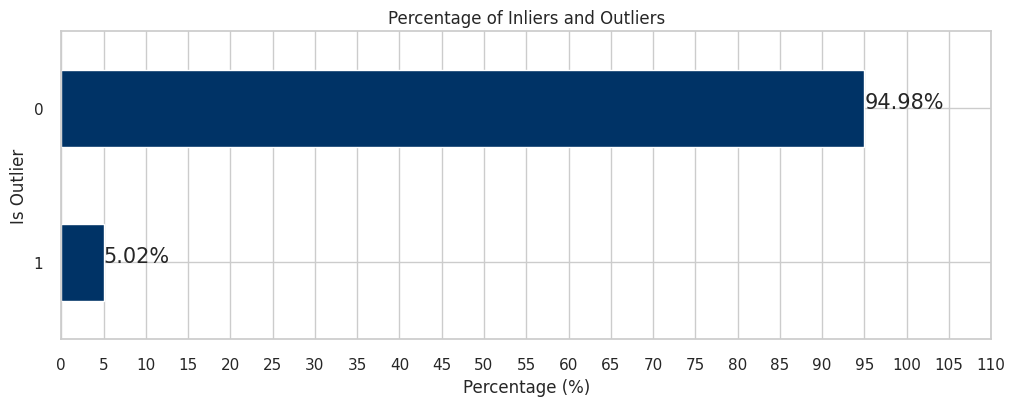

In [259]:
# Calculate the percentage of inliers and outliers
outlier_percentage = customer_data['Is_Outlier'].value_counts(normalize=True) * 100

# Plotting the percentage of inliers and outliers
plt.figure(figsize=(12, 4))
outlier_percentage.plot(kind='barh', color='#003366')

# Adding the percentage labels on the bars
for index, value in enumerate(outlier_percentage):
    plt.text(value, index, f'{value:.2f}%', fontsize=15)

plt.title('Percentage of Inliers and Outliers')
plt.xticks(ticks=np.arange(0, 115, 5))
plt.xlabel('Percentage (%)')
plt.ylabel('Is Outlier')
plt.gca().invert_yaxis()
plt.show()

In [260]:
# Separate the outliers for analysis
outliers_data = customer_data[customer_data['Is_Outlier'] == 1]

# Remove the outliers from the main dataset
customer_data_cleaned = customer_data[customer_data['Is_Outlier'] == 0]

# Drop the 'Outlier_Scores' and 'Is_Outlier' columns
customer_data_cleaned = customer_data_cleaned.drop(columns=['Outlier_Scores', 'Is_Outlier'])

# Reset the index of the cleaned data
customer_data_cleaned.reset_index(drop=True, inplace=True)

In [261]:
customer_data_cleaned.shape[0]

4067

## Correlation Analysis

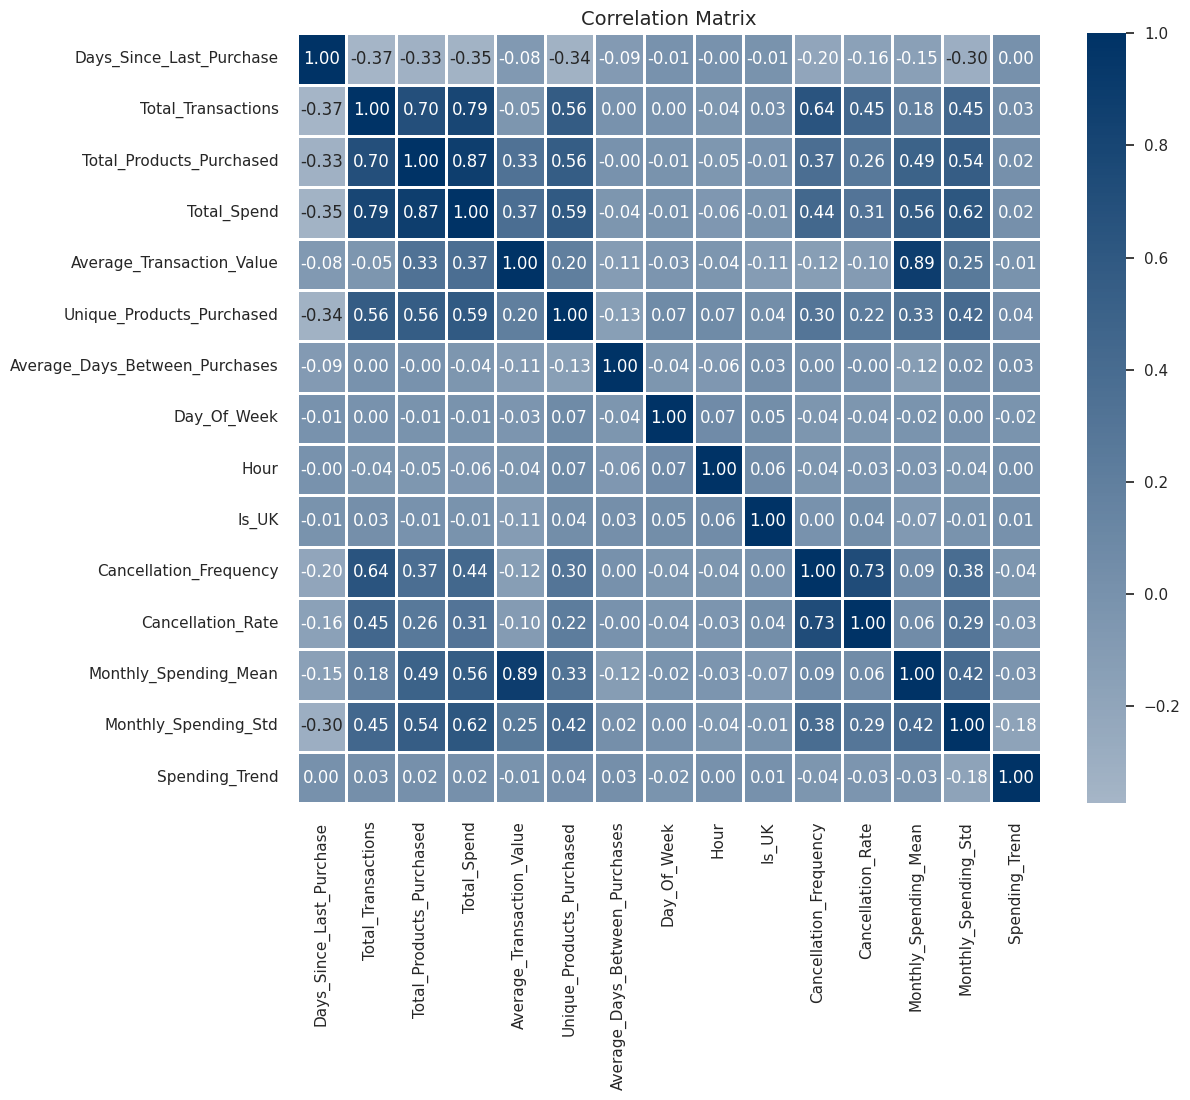

In [262]:
sns.set_style('whitegrid')

# Calculate the correlation matrix excluding the 'CustomerID' column
corr = customer_data_cleaned.drop(columns=['CustomerID']).corr()

# Define a custom colormap
blue_palette = sns.light_palette("#003366", as_cmap=True)

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr,cmap=blue_palette, annot=True, center=0, fmt='.2f', linewidths=2)
plt.title('Correlation Matrix', fontsize=14)
plt.show()

## Feature Scaling

In [263]:
scaler = StandardScaler()

In [264]:
# List of columns that don't need to be scaled
columns_to_exclude = ['CustomerID', 'Is_UK', 'Day_Of_Week']

# List of columns that need to be scaled
columns_to_scale = customer_data_cleaned.columns.difference(columns_to_exclude)

# Copy the cleaned dataset
customer_data_scaled = customer_data_cleaned.copy()

# Applying the scaler to the necessary columns in the dataset
customer_data_scaled[columns_to_scale] = scaler.fit_transform(customer_data_scaled[columns_to_scale])

# Display the first few rows of the scaled data
customer_data_scaled.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
0,12346.0,2.345802,-0.477589,-0.754491,-0.813464,-1.317106,-0.908471,-0.310564,1,-1.086929,1,0.420541,0.417623,-1.329018,-0.713318,0.090868
1,12347.0,-0.905575,0.707930,2.005048,2.366920,1.528132,0.815119,-0.128438,1,0.647126,0,-0.545753,-0.432111,0.989511,1.259961,0.116774
2,12348.0,-0.170744,-0.003381,1.863591,0.247087,0.343279,-0.570512,0.672476,3,2.814696,0,-0.545753,-0.432111,0.023997,0.466213,-0.491708
3,12349.0,-0.744516,-0.714692,-0.047205,0.262074,5.418285,0.291283,-0.310564,0,-1.520443,0,-0.545753,-0.432111,4.159521,-0.713318,0.090868
4,12350.0,2.194809,-0.714692,-0.534446,-0.596223,0.043327,-0.655002,-0.310564,2,1.514154,0,-0.545753,-0.432111,-0.220428,-0.713318,0.090868


## Dimensionality Reduction

In [265]:
# Setting CustomerID as the index column
customer_data_scaled.set_index('CustomerID', inplace=True)

# Apply PCA
pca = PCA().fit(customer_data_scaled)

# Calculate the Cumulative Sum of the Explained Variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Set the optimal k value (based on our analysis, we can choose 6)
optimal_k = 6

In [266]:
# Creating a PCA object with 6 components
pca = PCA(n_components=6)

# Fitting and transforming the original data to the new PCA dataframe
customer_data_pca = pca.fit_transform(customer_data_scaled)

# Creating a new dataframe from the PCA dataframe, with columns labeled PC1, PC2, etc.
customer_data_pca = pd.DataFrame(customer_data_pca, columns=['PC'+str(i+1) for i in range(pca.n_components_)])

# Adding the CustomerID index back to the new PCA dataframe
customer_data_pca.index = customer_data_scaled.index

In [267]:
customer_data_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6
CustomerID,,,,,,
12346.0,-2.186469,-1.705370,-1.576745,-1.008187,-0.411803,-1.658012
12347.0,3.290264,-1.387375,1.923310,0.930990,-0.010591,0.873150
12348.0,0.584684,0.585019,0.664727,0.655411,-0.470280,2.306657
12349.0,1.791116,-2.695652,5.850040,-0.853418,0.677111,-1.520098
12350.0,-1.997139,-0.542639,0.578781,-0.183682,-1.484838,0.062672


In [268]:
# Define a function to highlight the top 3 absolute values in each column of a dataframe
def highlight_top3(column):
    top3 = column.abs().nlargest(3).index
    return ['background-color:  #003366' if i in top3 else '' for i in column.index]

# Create the PCA component DataFrame and apply the highlighting function
pc_df = pd.DataFrame(pca.components_.T, columns=['PC{}'.format(i+1) for i in range(pca.n_components_)],
                     index=customer_data_scaled.columns)

pc_df.style.apply(highlight_top3, axis=0)

,PC1,PC2,PC3,PC4,PC5,PC6
Days_Since_Last_Purchase,-0.217859,-0.013986,0.067660,-0.273430,-0.240968,-0.373059
Total_Transactions,0.380301,0.014759,-0.259180,0.138165,-0.017356,-0.028257
Total_Products_Purchased,0.401425,0.007365,0.069133,0.134806,0.057476,-0.013373
Total_Spend,0.431260,0.010159,0.065165,0.092047,0.025202,-0.036947
Average_Transaction_Value,0.176225,-0.015544,0.589050,-0.114307,0.021847,-0.101738
Unique_Products_Purchased,0.324992,0.063346,0.014010,0.230502,-0.193981,0.124604
Average_Days_Between_Purchases,-0.022600,-0.036007,-0.127341,0.160627,0.753462,0.211787
Day_Of_Week,-0.026572,0.994650,-0.006591,-0.028870,0.058359,-0.060799
Hour,-0.024259,0.056388,-0.002019,0.226832,-0.528881,0.621915
Is_UK,-0.001014,0.007435,-0.018378,0.013419,-0.005353,0.014384


## K-Means Clustering

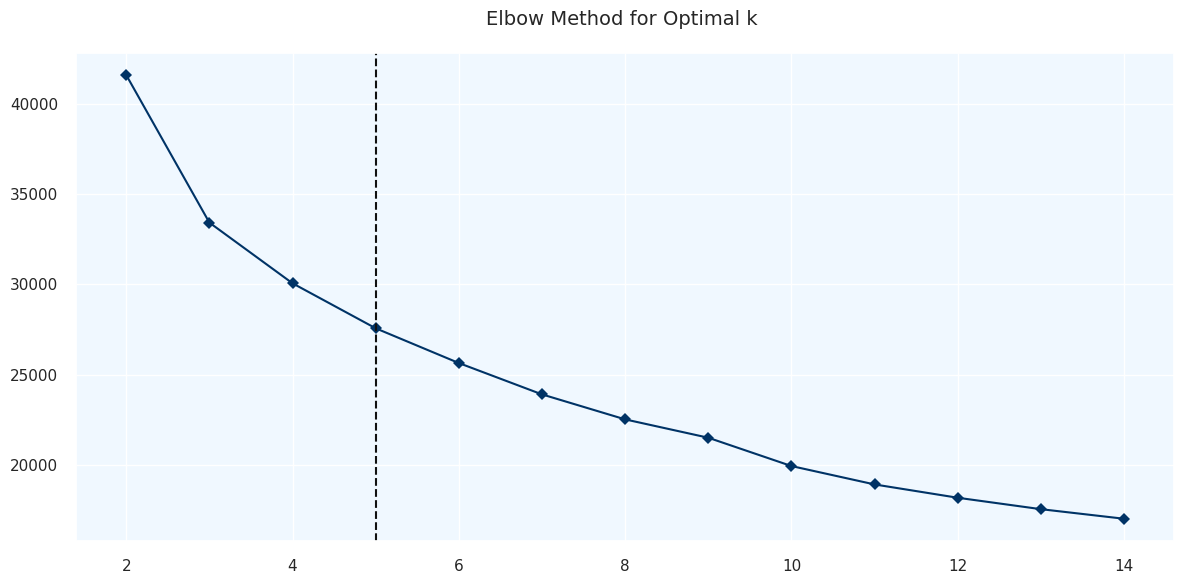

In [269]:
# Set plot style with light blue background and dark grid
sns.set(style='darkgrid', rc={'axes.facecolor': '#e6f2ff'})  # Light blue background

# Set orange color palette to blue gradient
blue_palette = ['#003366', '#1E90FF', '#4d88ff', '#89c2d9']  # Dark blue to light blue
sns.set_palette(blue_palette)

# Instantiate KMeans model
km = KMeans(init='k-means++', n_init=10, max_iter=100, random_state=0)

# Create figure with custom size
fig, ax = plt.subplots(figsize=(12, 6))

# Configure visualizer with blue theme
visualizer = KElbowVisualizer(
    km,
    k=(2, 15),
    timings=False,
    ax=ax,
    metric='distortion',
    locate_elbow=True
)

# Fit and customize appearance
visualizer.fit(customer_data_pca)
visualizer.ax.set_title('Elbow Method for Optimal k ', fontsize=14, pad=20)
visualizer.ax.set_facecolor('#f0f8ff')
plt.tight_layout()
plt.show()

In [270]:
# Apply KMeans clustering using the optimal k
kmeans = KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=100, random_state=0)
kmeans.fit(customer_data_pca)

# Get the frequency of each cluster
cluster_frequencies = Counter(kmeans.labels_)

# Create a mapping from old labels to new labels based on frequency
label_mapping = {label: new_label for new_label, (label, _) in
                 enumerate(cluster_frequencies.most_common())}

# Reverse the mapping to assign labels as per your criteria
label_mapping = {v: k for k, v in {2: 1, 1: 0, 0: 2}.items()}

# Apply the mapping to get the new labels
new_labels = np.array([label_mapping[label] for label in kmeans.labels_])

# Append the new cluster labels back to the original dataset
customer_data_cleaned['cluster'] = new_labels

# Append the new cluster labels to the PCA version of the dataset
customer_data_pca['cluster'] = new_labels

In [271]:
customer_data_cleaned.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend,cluster
0,12346.0,325,2,0,0.0,0.0,1,0.0,1,10,1,1,0.5,0.0,0.0,0.0,2
1,12347.0,2,7,2458,4310.0,615.714286,103,2.016575,1,14,0,0,0.0,615.714286,341.070789,4.486071,0
2,12348.0,75,4,2332,1437.24,359.31,21,10.884615,3,19,0,0,0.0,359.31,203.875689,-100.884,1
3,12349.0,18,1,630,1457.55,1457.55,72,0.0,0,9,0,0,0.0,1457.55,0.0,0.0,2
4,12350.0,310,1,196,294.4,294.4,16,0.0,2,16,0,0,0.0,294.4,0.0,0.0,2


## Clustering Evaluation

In [272]:
# Create separate data frames for each cluster
cluster_0 = customer_data_pca[customer_data_pca['cluster'] == 0]
cluster_1 = customer_data_pca[customer_data_pca['cluster'] == 1]
cluster_2 = customer_data_pca[customer_data_pca['cluster'] == 2]

colors = ['#e8000b', '#1ac938', '#023eff']

# Create a 3D scatter plot
fig = go.Figure()

# Add data points for each cluster separately and specify the color
fig.add_trace(go.Scatter3d(x=cluster_0['PC1'], y=cluster_0['PC2'], z=cluster_0['PC3'],
                           mode='markers', marker=dict(color=colors[0], size=5, opacity=0.4), name='Cluster 0'))
fig.add_trace(go.Scatter3d(x=cluster_1['PC1'], y=cluster_1['PC2'], z=cluster_1['PC3'],
                           mode='markers', marker=dict(color=colors[1], size=5, opacity=0.4), name='Cluster 1'))
fig.add_trace(go.Scatter3d(x=cluster_2['PC1'], y=cluster_2['PC2'], z=cluster_2['PC3'],
                           mode='markers', marker=dict(color=colors[2], size=5, opacity=0.4), name='Cluster 2'))

# Set the title and layout details
fig.update_layout(
    title=dict(text='3D Visualization of Customer Clusters in PCA Space', x=0.5),
    scene=dict(
        xaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC1'),
        yaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC2'),
        zaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC3'),
    ),
    width=900,
    height=800
)

# Show the plot
fig.show()

In [273]:
# Compute number of customers
num_observations = len(customer_data_pca)

# Separate the features and the cluster labels
X = customer_data_pca.drop('cluster', axis=1)
clusters = customer_data_pca['cluster']

# Compute the metrics
sil_score = silhouette_score(X, clusters)
calinski_score = calinski_harabasz_score(X, clusters)
davies_score = davies_bouldin_score(X, clusters)

# Create a table to display the metrics and the number of observations
table_data = [
    ["Number of Observations", num_observations],
    ["Silhouette Score", sil_score],
    ["Calinski Harabasz Score", calinski_score],
    ["Davies Bouldin Score", davies_score]
]

# Print the table
print(tabulate(table_data, headers=["Metric", "Value"], tablefmt='pretty'))

+-------------------------+---------------------+
|         Metric          |        Value        |
+-------------------------+---------------------+
| Number of Observations  |        4067         |
|    Silhouette Score     | 0.23622848017098874 |
| Calinski Harabasz Score | 1257.1747766540636  |
|  Davies Bouldin Score   | 1.3682695376074665  |
+-------------------------+---------------------+


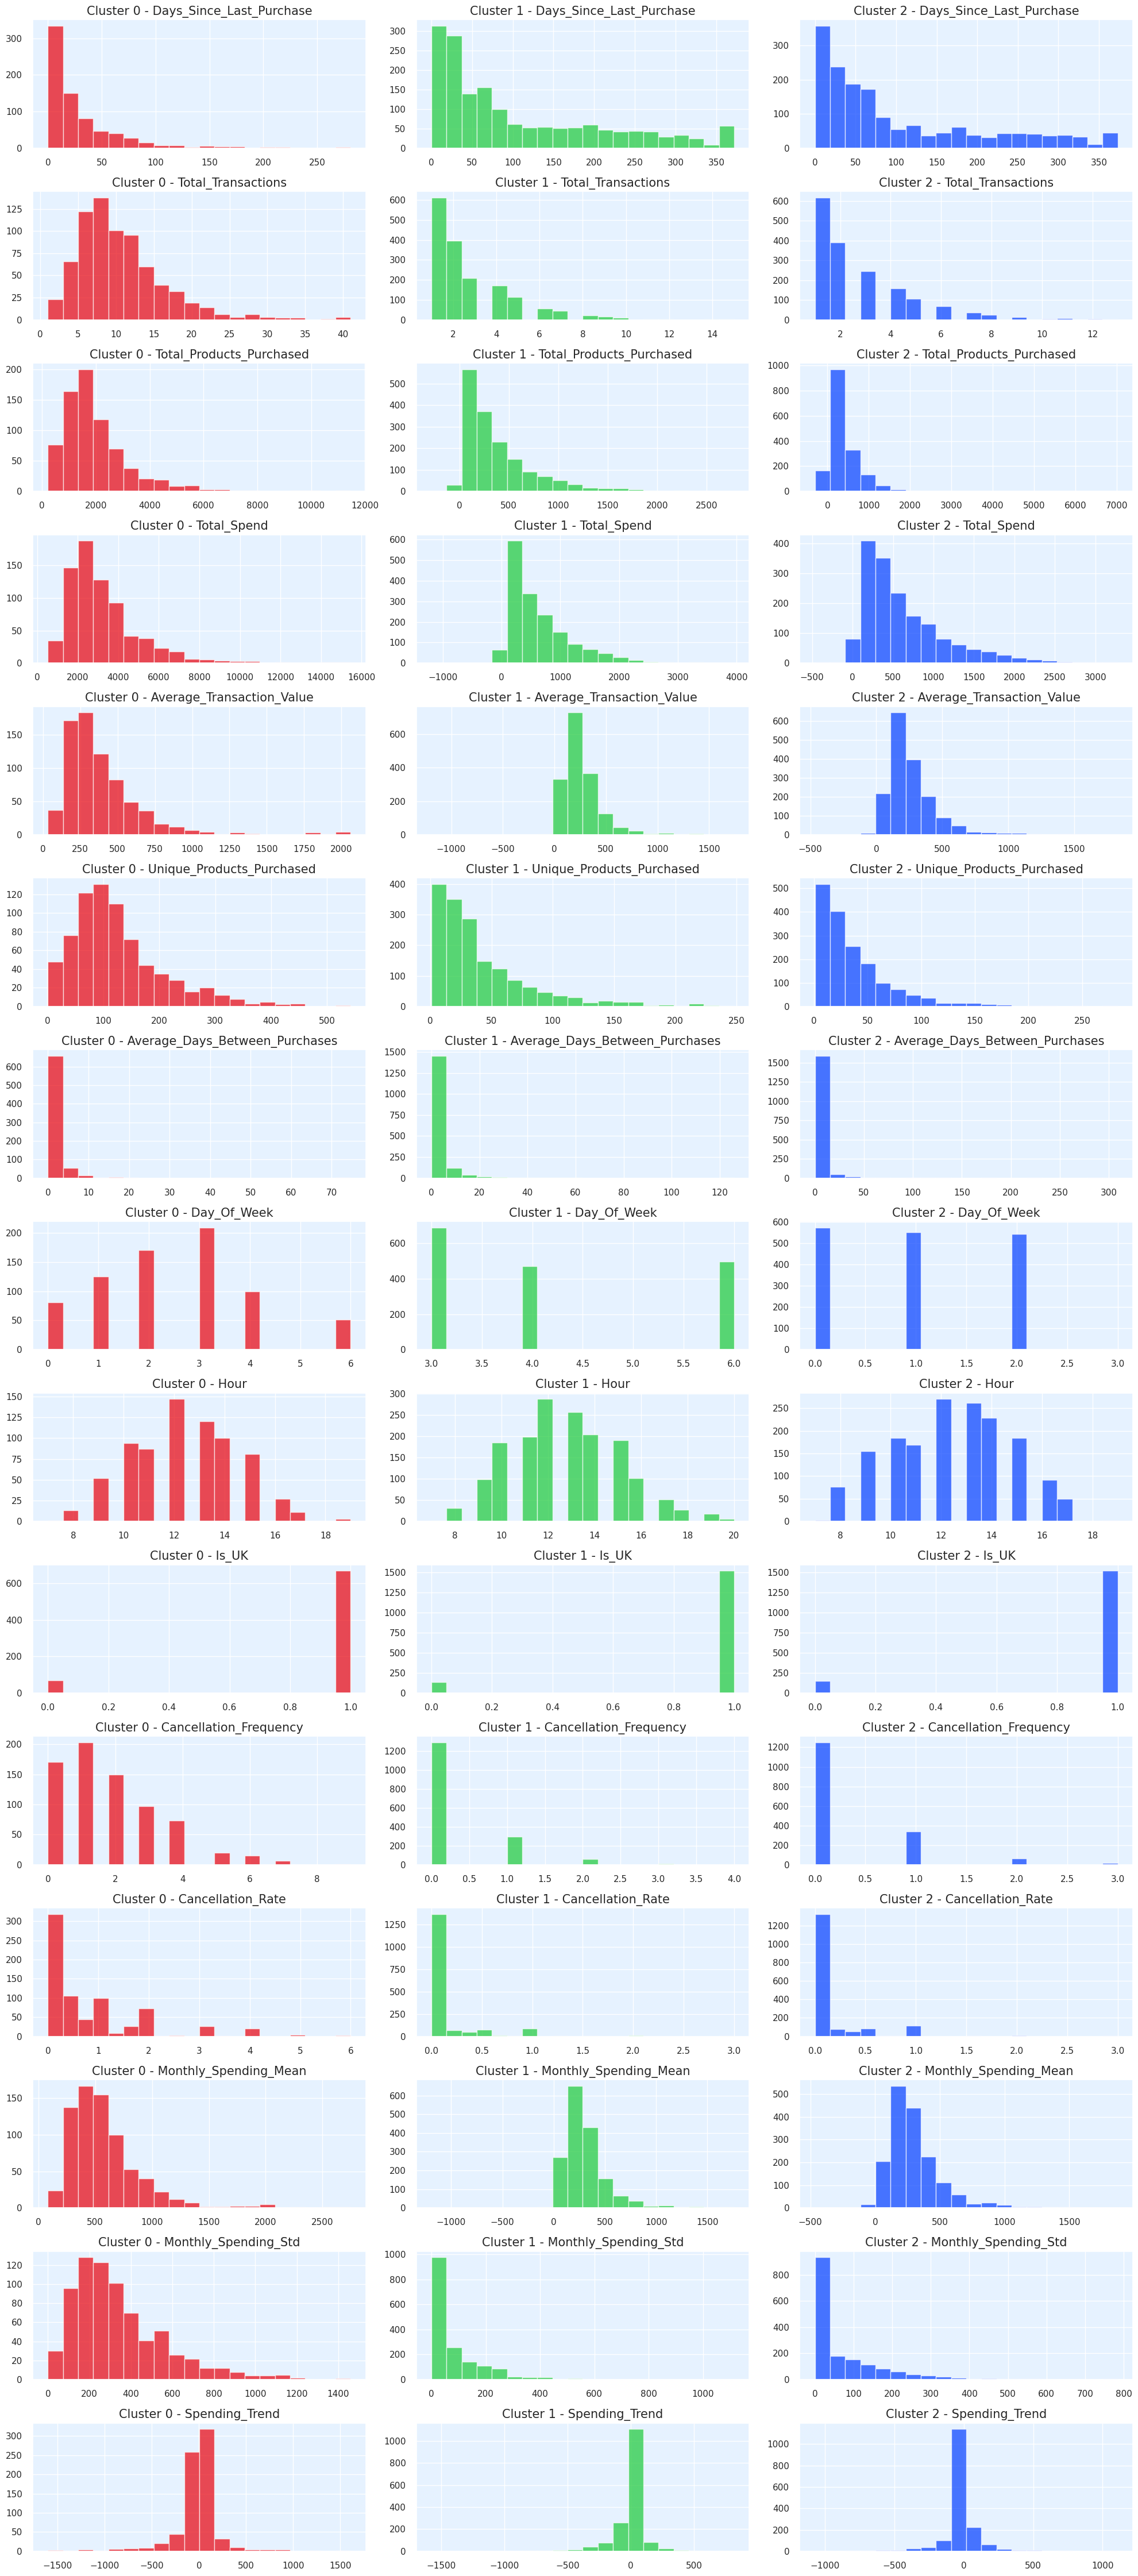

In [274]:
# Plot histograms for each feature segmented by the clusters
features = customer_data_cleaned.columns[1:-1]
clusters = customer_data_cleaned['cluster'].unique()
clusters.sort()

# Setting up the subplots
n_rows = len(features)
n_cols = len(clusters)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 3*n_rows))

# Plotting histograms
for i, feature in enumerate(features):
    for j, cluster in enumerate(clusters):
        data = customer_data_cleaned[customer_data_cleaned['cluster'] == cluster][feature]
        axes[i, j].hist(data, bins=20, color=colors[j], edgecolor='w', alpha=0.7)
        axes[i, j].set_title(f'Cluster {cluster} - {feature}', fontsize=15)
        axes[i, j].set_xlabel('')
        axes[i, j].set_ylabel('')

# Adjusting layout to prevent overlapping
plt.tight_layout()
plt.show()

# Recommendation System

In [287]:
# Step 1: Extract the CustomerIDs of the outliers and remove their transactions from the main dataframe
outlier_customer_ids = outliers_data['CustomerID'].astype('float').unique()
df_filtered = df[~df['CustomerID'].isin(outlier_customer_ids)]

# Step 2: Ensure consistent data type for CustomerID across both dataframes before merging
customer_data_cleaned['CustomerID'] = customer_data_cleaned['CustomerID'].astype('float')

# Step 3: Merge the transaction data with the customer data to get the cluster information for each transaction
merged_data = df_filtered.merge(customer_data_cleaned[['CustomerID', 'cluster']], on='CustomerID', how='inner')

# Step 4: Identify the top 10 best-selling products in each cluster based on the total quantity sold
best_selling_products = merged_data.groupby(['cluster', 'StockCode', 'Description'])['Quantity'].sum().reset_index()
best_selling_products = best_selling_products.sort_values(by=['cluster', 'Quantity'], ascending=[True, False])
top_products_per_cluster = best_selling_products.groupby('cluster').head(10)

# Step 5: Create a record of products purchased by each customer in each cluster
customer_purchases = merged_data.groupby(['CustomerID', 'cluster', 'StockCode'])['Quantity'].sum().reset_index()

# Step 6: Generate recommendations for each customer in each cluster
recommendations = []
for cluster in top_products_per_cluster['cluster'].unique():
    top_products = top_products_per_cluster[top_products_per_cluster['cluster'] == cluster]
    customers_in_cluster = customer_data_cleaned[customer_data_cleaned['cluster'] == cluster]['CustomerID']

    for customer in customers_in_cluster:
        # Identify products already purchased by the customer
        customer_purchased_products = customer_purchases[(customer_purchases['CustomerID'] == customer) &
                                                         (customer_purchases['cluster'] == cluster)]['StockCode'].tolist()

        # Find top 3 products in the best-selling list that the customer hasn't purchased yet
        top_products_not_purchased = top_products[~top_products['StockCode'].isin(customer_purchased_products)]
        top_3_products_not_purchased = top_products_not_purchased.head(3)

        # Only append if we found recommendations
        if len(top_3_products_not_purchased) > 0:
            recommendations.append([customer, cluster] + top_3_products_not_purchased[['StockCode', 'Description']].values.flatten().tolist())

# Step 7: Create a dataframe from the recommendations list and merge it with the original customer data
if recommendations:  # Only proceed if we have recommendations
    recommendations_df = pd.DataFrame(recommendations, columns=['CustomerID', 'cluster', 'Rec1_StockCode', 'Rec1_Description',
                                                             'Rec2_StockCode', 'Rec2_Description', 'Rec3_StockCode', 'Rec3_Description'])
    customer_data_with_recommendations = customer_data_cleaned.merge(recommendations_df, on=['CustomerID', 'cluster'], how='right')

    # Display 10 random rows from the customer_data_with_recommendations dataframe
    display(customer_data_with_recommendations.set_index('CustomerID').iloc[:, -6:].sample(10, random_state=0))
else:
    print("No recommendations could be generated - check your data processing steps.")

,Rec1_StockCode,Rec1_Description,Rec2_StockCode,Rec2_Description,Rec3_StockCode,Rec3_Description
CustomerID,,,,,,
13243.0,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,84879,ASSORTED COLOUR BIRD ORNAMENT,15036,ASSORTED COLOURS SILK FAN
13232.0,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,84879,ASSORTED COLOUR BIRD ORNAMENT,15036,ASSORTED COLOURS SILK FAN
14997.0,18007,ESSENTIAL BALM 3.5G TIN IN ENVELOPE,84879,ASSORTED COLOUR BIRD ORNAMENT,17003,BROCADE RING PURSE
14948.0,18007,ESSENTIAL BALM 3.5G TIN IN ENVELOPE,84879,ASSORTED COLOUR BIRD ORNAMENT,17003,BROCADE RING PURSE
12596.0,18007,ESSENTIAL BALM 3.5G TIN IN ENVELOPE,84879,ASSORTED COLOUR BIRD ORNAMENT,17003,BROCADE RING PURSE
16686.0,22616,PACK OF 12 LONDON TISSUES,85099B,JUMBO BAG RED RETROSPOT,84879,ASSORTED COLOUR BIRD ORNAMENT
17101.0,18007,ESSENTIAL BALM 3.5G TIN IN ENVELOPE,84879,ASSORTED COLOUR BIRD ORNAMENT,17003,BROCADE RING PURSE
14954.0,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,84879,ASSORTED COLOUR BIRD ORNAMENT,15036,ASSORTED COLOURS SILK FAN
18123.0,18007,ESSENTIAL BALM 3.5G TIN IN ENVELOPE,84879,ASSORTED COLOUR BIRD ORNAMENT,17003,BROCADE RING PURSE
